# ***Data Science com Python***
## Modelagem e Avaliação de Resutados - Classificação
### Camila Teixeira

Professor: Lucas Roberto Correa

Estudo de caso: Base de dados de pessoas que um banco entrou em contato para oferecer um investimento. Nessa base consta quem já aceitou e quem não aceitou fazer o investimento. 
O objetivo deste modelo é saber quem será mais propenso a aceitar a proposta e ordená-los nesse sentido.

## Import packages

In [1]:
# Manipução de dados
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Quebra dos dados de train / test
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Modelo de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Validação cruzada
from sklearn.model_selection import cross_val_score

# Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Tuning de hiperparâmetros
from sklearn.model_selection import GridSearchCV

In [2]:
# adicção de algumas configurações de visualização

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
metadados = pd.read_excel('metadata.xlsx')

## Bases em: Kaggle

In [4]:
metadados

,Feature,Feature_Type,Description
0,age,numeric,age of a person
1,job,"Categorical,nominal","type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,"categorical,nominal","marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,"categorical,nominal","('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,"categorical,nominal","has credit in default? ('no','yes','unknown')"
5,housing,"categorical,nominal","has housing loan? ('no','yes','unknown')"
6,loan,"categorical,nominal","has personal loan? ('no','yes','unknown')"
7,contact,"categorical,nominal","contact communication type ('cellular','telephone')"
8,month,"categorical,ordinal","last contact month of year ('jan', 'feb', 'mar', …, 'nov', 'dec')"
9,dayofweek,"categorical,ordinal","last contact day of the week ('mon','tue','wed','thu','fri')"


In [5]:
df = pd.read_csv('new_train.csv', sep=',')

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


In [8]:
df.corr()

,age,duration,campaign,pdays,previous
age,1.000000,-0.001841,0.003302,-0.032011,0.020670
duration,-0.001841,1.000000,-0.075663,-0.047127,0.022538
campaign,0.003302,-0.075663,1.000000,0.053795,-0.079051
pdays,-0.032011,-0.047127,0.053795,1.000000,-0.589601
previous,0.020670,0.022538,-0.079051,-0.589601,1.000000


In [9]:
df['poutcome'].value_counts()

nonexistent    28416
failure         3429
success         1105
Name: poutcome, dtype: int64

## Criar uma nova variavel para a modelagem com base em poutcome e previous

In [10]:
df['difficulty'] = -1 # para tudo que for desconhecido

# procurar se df['poutcome'] for igual a 'success' e df['previous'] estiver entre (0,1) que significa pouco contato,
# df['difficulty'] receberá o valor 0.

df.loc[(df['poutcome'] == 'success') & (df['previous'].between(0,1)), 'difficulty'] = 0 # facil
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(2,4)), 'difficulty'] = 1 # médio
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(5,7)), 'difficulty'] = 2 # dificil
df.loc[(df['poutcome'] == 'nonexistent') & (df['previous'] > 7), 'difficulty'] = 3 # muito dificil
df.loc[(df['poutcome'] == 'failure'), 'difficulty'] = 4 # impossivel

In [11]:
df['difficulty'].value_counts()

-1    28416
 4     3429
 0      697
 1      391
 2       17
Name: difficulty, dtype: int64

## ABT - Analytical Base Table

In [12]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'difficulty'],
      dtype='object')

In [13]:
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
difficulty     0
dtype: int64

In [14]:
df.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
difficulty      int64
dtype: object

## Separar da Var resposta das variáveis explicativas

In [15]:
explicativas = df.drop(columns=['y'])

In [16]:
explicativas.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,difficulty
32945,28,services,single,high.school,no,yes,no,cellular,jul,tue,192,1,999,0,nonexistent,-1
32946,52,technician,married,professional.course,no,yes,no,cellular,nov,fri,64,1,999,1,failure,4
32947,54,admin.,married,basic.9y,no,no,yes,cellular,jul,mon,131,4,999,0,nonexistent,-1
32948,29,admin.,married,university.degree,no,no,no,telephone,may,fri,165,1,999,0,nonexistent,-1
32949,35,admin.,married,university.degree,no,no,yes,telephone,jun,tue,544,3,999,0,nonexistent,-1


## Tratar a nossa variável resp

In [17]:
var_resp = df['y']
var_resp.value_counts()

no     29238
yes     3712
Name: y, dtype: int64

In [18]:
var_resp = var_resp.replace('no', 0)
var_resp = var_resp.replace('yes', 1)

In [19]:
var_resp.value_counts()

0    29238
1     3712
Name: y, dtype: int64

In [20]:
explicativas.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,difficulty
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-1
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,4
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,-1
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-1


## Tratar as variáveis explicativas categóricas

In [21]:
expl_cat = explicativas[['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','difficulty']]

In [22]:
expl_num = explicativas[['age','duration','campaign','pdays','previous']]

In [23]:
# Para fazer o encoding das variáveis usar o método get_dummies que converte dados categóricos em variáveis fictícias ou indicadores.

expl_cat_encoding = pd.get_dummies(expl_cat,
                                   prefix_sep='_',
                                   columns=expl_cat.columns,
                                   drop_first=True)

In [24]:
expl_cat_encoding.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [25]:
explicativas_tratadas = expl_num.merge(expl_cat_encoding,
                                       left_index=True,
                                       right_index=True)

In [26]:
explicativas_tratadas.head()

,age,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
0,49,227,4,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
1,37,202,2,999,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,78,1148,1,999,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,36,120,2,999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
4,59,368,2,999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [27]:
explicativas_tratadas.shape

(32950, 52)

## Feature Selection

In [28]:
# chi2 para variáveis categóricas
# MinMaxScaler dimensiona todos os recursos de dados no intervalo [0, 1] ou então no intervalo [-1, 1] se houver valores negativos no conjunto de dados. Esta escala comprime todos os inliers na faixa estreita [0, 0,005].
# fit_transform calcula a média e a variância de cada uma das características presentes nos dados.Ele é usado nos dados de treinamento para que possamos dimensionar os dados de treinamento e também aprender os parâmetros de dimensionamento.

expl_cat_norm = MinMaxScaler().fit_transform(expl_cat_encoding)
expl_cat_norm

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
# Seleção
# SelectKBest seleciona de acordo com os 'K' maiores

chi_selector = SelectKBest(chi2, k=5)

# Usar o método fit para o processo de treinamento aprender quais highest scores (melhores) de K das variáveis explicativas interferem nas variáveis respostas.

chi_selector.fit(expl_cat_norm, var_resp)

SelectKBest(k=5, score_func=<function chi2 at 0x00000277091E5700>)

In [30]:
# traz do array 'expl_cat_norm' quais ficam ou não

chi_selector.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False,  True,  True,  True,
       False, False])

In [31]:
# Traz quais recursos foram selecionados

chi_support = chi_selector.get_support()
chi_feature = expl_cat_encoding.loc[:, chi_support].columns.tolist()
chi_feature

['month_mar', 'month_oct', 'poutcome_success', 'difficulty_0', 'difficulty_1']

## Seleção de variáveis numéricas

In [32]:
# No método 'LogisticRegression' o algoritmo prevê a probabilidade de ocorrência de um evento ajustando dados para uma função logística

rfe_selector = RFE(estimator=LogisticRegression(random_state=42, max_iter=200), n_features_to_select=3, step=1)

In [33]:
# Usar o método fit para o processo de treinamento aprender quais highest scores (melhores) de K das variáveis explicativas interferem nas variáveis respostas.

rfe_selector.fit(expl_num, var_resp)

RFE(estimator=LogisticRegression(max_iter=200, random_state=42),
    n_features_to_select=3)

In [34]:
# Traz quais recursos foram selecionados

rfe_support = rfe_selector.get_support()
rfe_feature = expl_num.loc[:, rfe_support].columns.tolist()
rfe_feature

['age', 'campaign', 'previous']

## Base a ser considerada no processo de modelagem

In [35]:
# Variáveis numéricas a serem usadas na modelagem

expl_num_feature_selection = expl_num[['age', 'campaign', 'previous']]
expl_num_feature_selection.head()

,age,campaign,previous
0,49,4,0
1,37,2,1
2,78,1,0
3,36,2,0
4,59,2,0


In [36]:
# Variáveis explicativas a serem usadas na modelagem

expl_cat_feature_selection = expl_cat[['month', 'poutcome', 'difficulty']]
expl_cat_feature_selection.head()

,month,poutcome,difficulty
0,nov,nonexistent,-1
1,nov,failure,4
2,jul,nonexistent,-1
3,may,nonexistent,-1
4,jun,nonexistent,-1


In [37]:
# Para fazer o encoding das variáveis usar o método get_dummies que converte dados categóricos em variáveis fictícias ou indicadores.

expl_cat_feature_selection = pd.get_dummies(expl_cat_feature_selection, prefix_sep='_', columns=expl_cat_feature_selection.columns, drop_first=True)
expl_cat_feature_selection.head()

,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [38]:
explicativas_modelagem = expl_num_feature_selection.merge(expl_cat_feature_selection, 
                                                          left_index=True,
                                                          right_index=True)

In [39]:
explicativas_modelagem.tail()

,age,campaign,previous,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2,difficulty_4
32945,28,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
32946,52,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
32947,54,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
32948,29,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
32949,35,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


## Quebra dos dados entre train / test

In [40]:
x_treino, x_teste, y_treino, y_teste = train_test_split(explicativas_modelagem,
                                                        var_resp,
                                                        test_size=0.3,
                                                        random_state=42)

## O Algoritmo

Para treinamento de um modelo de modelagem clássico:
* Import do pacote de ML
* Instancie o obj em memória
* Treinamento
* Auferir os resultados

In [41]:
# Algoritmo de árvore

tree = DecisionTreeClassifier(random_state=42)

In [42]:
tree

DecisionTreeClassifier(random_state=42)

In [45]:
# Random Forest é um método de aprendizado de máquina utilizado para problemas que envolvam classificação ou regressão.
# Ele se baseia em uma coleção de árvores de decisão em que os são vetores aleatórios independentes e identicamente distribuídos.

rf = RandomForestClassifier(n_estimators=400,
                            random_state=42)

In [46]:
rf

RandomForestClassifier(n_estimators=400, random_state=42)

O algoritmo **Gradient Boosting** é uma técnica de aprendizado de máquina para problemas de regressão e classificação, que produz um modelo de previsão na forma de um conjunto de modelos de previsão fracos, geralmente árvores de decisão. Ele constrói o modelo em etapas, como outros métodos de reforço, e os generaliza, permitindo a otimização de uma função de perda diferenciável arbitrária.
https://medium.com/equals-lab/uma-breve-introdu%C3%A7%C3%A3o-ao-algoritmo-de-machine-learning-gradient-boosting-utilizando-a-biblioteca-311285783099

In [47]:

gb = GradientBoostingClassifier(n_estimators=400, 
                                random_state=42)

In [48]:
gb

GradientBoostingClassifier(n_estimators=400, random_state=42)

In [49]:
tree.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=42)

In [50]:
rf.fit(x_treino, y_treino)

RandomForestClassifier(n_estimators=400, random_state=42)

In [51]:
gb.fit(x_treino, y_treino)

GradientBoostingClassifier(n_estimators=400, random_state=42)

## Acurácia da árvore

In [52]:
accuracy_score(y_treino, tree.predict(x_treino))

0.9274658573596358

In [53]:
accuracy_score(y_teste, tree.predict(x_teste))

0.8823469903894791

## Acurácia da RandomForest

In [54]:
accuracy_score(y_treino, rf.predict(x_treino))

0.9274658573596358

In [55]:
accuracy_score(y_teste, rf.predict(x_teste))

0.8845725847243298

## Acuraria do GradientBoosting

In [56]:
accuracy_score(y_treino, gb.predict(x_treino))

0.9065683936700628

In [57]:
accuracy_score(y_teste, gb.predict(x_teste))

0.8932726353060192

## Cross Validation

In [58]:
# O método Cross Validation consiste em particionar os dados em conjuntos(partes), onde um conjunto é utilizado para treino e 
# outro conjunto é utilizado para teste e avaliação do desempenho do modelo.

tree_cv = cross_val_score(estimator=tree,
                          X=x_treino,
                          y=y_treino,
                          cv=5,
                          scoring=make_scorer(accuracy_score))

In [59]:
tree_cv

array([0.88792543, 0.89182744, 0.88163885, 0.88424019, 0.88575764])

In [60]:
tree_cv

array([0.88792543, 0.89182744, 0.88163885, 0.88424019, 0.88575764])

Relembrando o treinamento padrão dos algoritmos e observando o quanto os hiperparametros mudam nos resultados dos algoritmos.

In [61]:
x_treino.count()

age                     23065
campaign                23065
previous                23065
month_aug               23065
month_dec               23065
month_jul               23065
month_jun               23065
month_mar               23065
month_may               23065
month_nov               23065
month_oct               23065
month_sep               23065
poutcome_nonexistent    23065
poutcome_success        23065
difficulty_0            23065
difficulty_1            23065
difficulty_2            23065
difficulty_4            23065
dtype: int64

In [62]:
# Simulando com valores distintos de n para o primeiro conjunto de treinamento:
# criterion= ("entropy")
# max_depth= (50,100) 
# min_samples_split=(5, 50) 
# min_samples_leaf= (40, 200)


tree_modificada = DecisionTreeClassifier(criterion="entropy", max_depth=50, min_samples_leaf=5, min_samples_split=40)

In [63]:
tree_modificada.fit(x_treino, y_treino)

DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=5,
                       min_samples_split=40)

In [64]:
accuracy_score(y_treino, tree_modificada.predict(x_treino))

0.9042705397788857

In [65]:
tree_modificada = DecisionTreeClassifier(criterion="entropy", max_depth=100, min_samples_leaf=50, min_samples_split=200)

In [66]:
tree_modificada.fit(x_treino, y_treino)

DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=50,
                       min_samples_split=200)

In [67]:
accuracy_score(y_treino, tree_modificada.predict(x_treino))

0.8997181877303273

In [68]:
accuracy_score(y_teste, tree_modificada.predict(x_teste))

0.8941831057157309

## Tuning de Hiperparâmetros

### Passos

 1. import do pacote
 2. chamada do objeto (estimador)
 3. dicionario com os conjuntos de hiperparametros
 4. chamada do objeto GridSearch
 5. fit (treinamento)
 6. verificar o resultado

In [75]:
# 1 - import do pacote

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [76]:
# 2 - chamada do objeto (estimador)

rf_grid_estimator = RandomForestClassifier()


In [77]:
# 3 - dicionario com os conjuntos de hiperparametros

rf_grid_dc = {
    'n_estimators':[50,100,200,500],
    'criterion':['gini','entropy'],
    'bootstrap':[True,False],
    'random_state':[42]
}

In [78]:
rf_grid_dc

{'n_estimators': [50, 100, 200, 500],
 'criterion': ['gini', 'entropy'],
 'bootstrap': [True, False],
 'random_state': [42]}

In [79]:
# 4 - chamada do objeto GridSearch

rf_grid = GridSearchCV(rf_grid_estimator,
                       rf_grid_dc,
                       cv=2,
                       scoring=make_scorer(accuracy_score))

In [80]:
rf_grid

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 200, 500],
                         'random_state': [42]},
             scoring=make_scorer(accuracy_score))

In [81]:
# 5 - it (treinamento)

rf_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 200, 500],
                         'random_state': [42]},
             scoring=make_scorer(accuracy_score))

In [84]:
rf_grid.best_estimator_

RandomForestClassifier(n_estimators=200, random_state=42)

In [85]:
# 6 - verificar o resultado

rf_grid.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'n_estimators': 200,
 'random_state': 42}

## Tuning de Hiperparâmetros explorando demais métricas

### Gradient Boosting

In [86]:
# 1
from sklearn.ensemble import GradientBoostingClassifier

In [87]:
# 1
from sklearn.model_selection import GridSearchCV

In [88]:
# 2
gb_grid_estimator = GradientBoostingClassifier()

In [89]:
# 3
gb_grid_dc = {
    'n_estimators':[100,200,500],
    'min_samples_split':[2,40],
    'min_samples_leaf':[2,100],
    'random_state':[42]
    
}

In [90]:
gb_grid_dc

{'n_estimators': [100, 200, 500],
 'min_samples_split': [2, 40],
 'min_samples_leaf': [2, 100],
 'random_state': [42]}

In [91]:
# 4
gb_grid = GridSearchCV(gb_grid_estimator,
                       gb_grid_dc,
                       scoring=make_scorer(roc_auc_score),
                       cv=5)

In [92]:
# 4
gb_grid_acc = GridSearchCV(gb_grid_estimator,
                       gb_grid_dc,
                       scoring=make_scorer(accuracy_score),
                       cv=2)

In [93]:
# 5
gb_grid_acc.fit(x_treino, y_treino)

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'min_samples_leaf': [2, 100],
                         'min_samples_split': [2, 40],
                         'n_estimators': [100, 200, 500],
                         'random_state': [42]},
             scoring=make_scorer(accuracy_score))

In [94]:
accuracy_score(y_treino, gb_grid_acc.predict(x_treino))

0.9037502709733363

In [95]:
accuracy_score(y_teste, gb_grid_acc.predict(x_teste))

0.8946889226100152

In [96]:
gb_grid_2 = GridSearchCV(gb_grid_estimator,
                       gb_grid_dc,
                       scoring='roc_auc',
                       cv=5)

# ref.: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [99]:
gb_grid

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'min_samples_leaf': [2, 100],
                         'min_samples_split': [2, 40],
                         'n_estimators': [100, 200, 500],
                         'random_state': [42]},
             scoring=make_scorer(roc_auc_score))

In [100]:
# 5

gb_grid.fit(x_treino, y_treino)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'min_samples_leaf': [2, 100],
                         'min_samples_split': [2, 40],
                         'n_estimators': [100, 200, 500],
                         'random_state': [42]},
             scoring=make_scorer(roc_auc_score))

In [101]:
gb_grid.best_params_

{'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 42}

In [102]:
gb_grid.best_score_

0.5921775553994446

In [103]:
roc_auc_score(y_teste, gb_grid.predict(x_teste))

0.5996638163337749

## Métricas

In [104]:
precision_score(y_teste, gb_grid.predict(x_teste))

0.6222222222222222

In [105]:
recall_score(y_teste, gb_grid.predict(x_teste))

0.21686746987951808

In [106]:
cf_matrix = confusion_matrix(y_teste, gb_grid.predict(x_teste))
cf_matrix

array([[8570,  153],
       [ 910,  252]], dtype=int64)

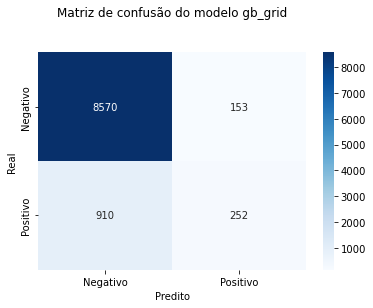

In [109]:
# annot para mostrar os valores dentro do plot, cmap para usar uma escalade azul, fmt formata o número como string.
ax = sns.heatmap(cf_matrix, 
                 annot=True,
                 cmap='Blues',
                 fmt='.4g')

# colocar o título
ax.set_title("Matriz de confusão do modelo gb_grid\n\n")

# colocar rótulo do eixo
ax.set_xlabel("Predito")

# colocar rótulo do eixo
ax.set_ylabel("Real")

# colocar rótulo do dado
ax.xaxis.set_ticklabels(['Negativo', 'Positivo'])
ax.yaxis.set_ticklabels(['Negativo', 'Positivo'])

plt.show()

## Plot curva ROC / AUC

A curva ROC mostra o quão bom o modelo criado pode distinguir entre duas coisas (já que é utilizado para classificação). Essas duas coisas podem ser 0 ou 1, ou positivo e negativo. Os melhores modelos conseguem distinguir com precisão o binômio.
Uma curva ROC traça “True Positive Rate vs. False Positive Rate” em diferentes limiares de classificação.

Assim, na tentativa de simplificar a análise da ROC, a AUC (“area under the ROC curve”) nada mais é que uma maneira de resumir a curva ROC em um único valor, agregando todos os limiares da ROC, calculando a “área sob a curva”.
O valor do AUC varia de 0,0 até 1,0 e o limiar entre a classe é 0,5. Ou seja, acima desse limite, o algoritmo classifica em uma classe e abaixo na outra classe.

Quanto maior o AUC, melhor.
https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772

In [110]:
# para trazer as probabilidades atreladas ao modelo

probs = gb_grid.predict_proba(x_teste)
probs

array([[0.95639744, 0.04360256],
       [0.41500537, 0.58499463],
       [0.92820103, 0.07179897],
       ...,
       [0.84407388, 0.15592612],
       [0.92266856, 0.07733144],
       [0.8653447 , 0.1346553 ]])

In [111]:
preds = probs[:, 1]
preds

array([0.04360256, 0.58499463, 0.07179897, ..., 0.15592612, 0.07733144,
       0.1346553 ])

In [112]:
taxa_falso_positivo, taxa_verdadeiro_positivo, threshold = roc_curve(y_teste, preds)

In [113]:
roc_auc = auc(taxa_falso_positivo, taxa_verdadeiro_positivo)

In [114]:
roc_auc

0.7335046940024227

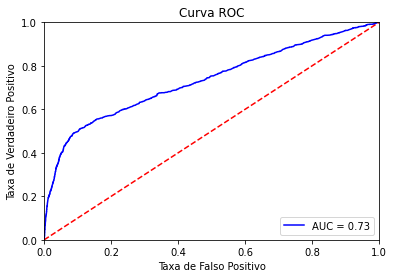

In [115]:
plt.title("Curva ROC")
plt.plot(taxa_falso_positivo,
         taxa_verdadeiro_positivo,
         'b',
         label= "AUC = %0.2f" % roc_auc)
plt.legend(loc= 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

## Exercicios

Proposta:

* Refazer o pipeline completo, para Gradient_boosting aproveitando os codigos ja desenvolvidos no notebook, usando todas as variáveis no processo de modelagem

* comparar os resultados com os anteriores

* Em tuning de hiperparametros: n_estimators:[500, 1000]; min_samples_leaf[2,100]; min_samples_split:[10,200]; random_state:[42]

### Passos a serem seguidos:
1. selecionar os dados de origem
2. quebrar as categoricas e numericas
3. tratar as variváveis categoricas
4. juntar os dados e formar a ABT
5. aplicar feature selection 
6. selecionar os dados para a ABT final de modelagem
7. estruturar o dicionario para tuning
8. instanciar os obj
9. executar o train
10. observar os resultados

In [116]:
df_exercicio = df.copy()

In [117]:
df_exercicio.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
difficulty      int64
dtype: object

In [118]:
df_exercicio_cat = df_exercicio.drop(columns=['age','duration','campaign','pdays','previous','difficulty','y'], axis=1)

In [119]:
df_exercicio_cat.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [120]:
df_exercicio_num = df_exercicio.drop(columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome','y'])

In [121]:
df_exercicio_num.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'difficulty'], dtype='object')

In [122]:
df_exercicio_cat_dum = pd.get_dummies(df_exercicio_cat,
                                      prefix_sep='_',
                                      columns=df_exercicio_cat.columns,
                                      drop_first=True)

In [123]:
df_exercicio_cat_dum.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [124]:
df_exercicio_feature_selection = df_exercicio_cat_dum.merge(df_exercicio_num, left_index=True, right_index=True)

In [125]:
df_exercicio_feature_selection.shape

(32950, 49)

In [126]:
df_exercicio_var_resp = df_exercicio['y']

In [127]:
df_exercicio_var_resp.head()

0     no
1     no
2    yes
3     no
4     no
Name: y, dtype: object

In [128]:
df_exercicio_var_resp = df_exercicio_var_resp.replace('no',0)
df_exercicio_var_resp = df_exercicio_var_resp.replace('yes',1)

In [129]:
df_exercicio_var_resp.head()

0    0
1    0
2    1
3    0
4    0
Name: y, dtype: int64

## Seleção de variáveis

In [130]:
# Variáveis categóricas

df_exercicio_cat_dum_norm = MinMaxScaler().fit_transform(df_exercicio_cat_dum)

selecao_chi = SelectKBest(chi2, k=5)
selecao_chi.fit(df_exercicio_cat_dum_norm, df_exercicio_var_resp)

suporte_chi = selecao_chi.get_support()
features_chi = df_exercicio_cat_dum.loc[:,suporte_chi].columns.tolist()
features_chi

['contact_telephone',
 'month_mar',
 'month_oct',
 'month_sep',
 'poutcome_success']

In [131]:
# Variáveis numéricas

selecao_rfe = RFE(estimator=LogisticRegression(random_state=42, max_iter=200), n_features_to_select=3, step=1)
selecao_rfe.fit(df_exercicio_num, df_exercicio_var_resp)

rfe_suporte = selecao_rfe.get_support()
rfe_features = df_exercicio_num.loc[:,rfe_suporte].columns.tolist()
rfe_features

['campaign', 'previous', 'difficulty']

In [132]:
df_exercicio_modelagem = df_exercicio_cat_dum.merge(df_exercicio_num, left_index=True, right_index=True)

In [133]:
x_treino_exer, x_teste_exer, y_treino_exer, y_teste_exer = train_test_split(df_exercicio_modelagem,
                                                                            df_exercicio_var_resp,
                                                                            test_size=0.3,
                                                                            random_state=42)

In [134]:
x_treino_exer.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,age,duration,campaign,pdays,previous,difficulty
24186,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,33,39,3,999,0,-1
18087,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,48,90,2,999,0,-1
6950,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,31,114,3,999,0,-1
8200,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,40,138,3,999,0,-1
16051,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,30,252,1,999,0,-1


In [137]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [138]:
exercicio_dict = {
    'n_estimators':[500,1000],
    'min_samples_leaf':[2,100],
    'min_samples_split':[10,200],
    'random_state':[42]
}

In [139]:
# modelo 

gb_exercicio = GradientBoostingClassifier(random_state=42)

In [140]:
# tuning

gb_exercicio_tuning = GridSearchCV(gb_exercicio,
                                   exercicio_dict,
                                   cv=2,
                                   scoring=make_scorer(accuracy_score))

In [141]:
gb_exercicio_tuning.fit(x_treino_exer, y_treino_exer)

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'min_samples_leaf': [2, 100],
                         'min_samples_split': [10, 200],
                         'n_estimators': [500, 1000], 'random_state': [42]},
             scoring=make_scorer(accuracy_score))

In [142]:
gb_exercicio_tuning.best_estimator_

GradientBoostingClassifier(min_samples_leaf=100, min_samples_split=10,
                           n_estimators=500, random_state=42)

In [143]:
gb_exercicio_tuning.best_score_

0.9083459372295741

In [144]:
accuracy_score(y_treino_exer, gb_exercicio_tuning.predict(x_treino_exer))

0.9216561890309993

In [145]:
accuracy_score(y_teste_exer, gb_exercicio_tuning.predict(x_teste_exer))

0.907233181588265

In [146]:
import joblib

In [147]:
joblib.dump(gb_exercicio_tuning, 'gb_exercicio_tuning.pkl')

['gb_exercicio_tuning.pkl']